In [159]:
import pandas as pd
import numpy as np
df = pd.read_csv(r"C:\Users\sarthak sanwal\ML_algo_trading\HDBK Historical Data.csv")
df.head()

,Date,close,open,high,low,Vol.,Change %
0,02/13/2023,"1,658.35","1,655.00","1,661.75","1,644.55",2.87M,0.08%
1,02-10-2023,"1,657.10","1,648.80","1,658.50","1,642.20",4.09M,0.40%
2,02-09-2023,"1,650.55","1,660.00","1,661.65","1,635.55",5.89M,-0.21%
3,02-08-2023,"1,654.00","1,654.25","1,668.20","1,650.00",4.22M,-0.01%
4,02-07-2023,"1,654.20","1,659.40","1,664.90","1,632.60",5.13M,0.15%


In [160]:
indexZeros = df[ df['Vol.'] == 0 ].index

df.drop(indexZeros , inplace=True)
df.loc[(df["Vol."] == 0 )]
df.isna().sum()

Date        0
close       0
open        0
high        0
low         0
Vol.        0
Change %    0
dtype: int64

In [161]:
df['high'] = df['high'].replace('[^\d.]', '', regex=True)
df['high'] = df['high'].astype(float)
df['close'] = df['close'].replace('[^\d.]', '', regex=True)
df['close'] = df['close'].astype(float)
df['open'] = df['open'].replace('[^\d.]', '', regex=True)
df['open'] = df['open'].astype(float)
df['low'] = df['low'].replace('[^\d.]', '', regex=True)
df['low'] = df['low'].astype(float)
df['low']

0       1644.55
1       1642.20
2       1635.55
3       1650.00
4       1632.60
         ...   
4995      21.41
4996      21.36
4997      21.45
4998      21.44
4999      21.45
Name: low, Length: 5000, dtype: float64

In [162]:
import numpy as np
import pandas_ta as ta
from scipy.stats import linregress
#df.ta.indicators()
#help(ta.atr)
df['ATR'] = df.ta.atr(length=20)
df['RSI'] = df.ta.rsi()
df['Average'] = df.ta.midprice(length=1) #midprice
df['MA40'] = df.ta.sma(length=40)
df['MA80'] = df.ta.sma(length=80)
df['MA160'] = df.ta.sma(length=160)

def get_slope(array):
    y = np.array(array)
    x = np.arange(len(y))
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope

# Rolling window size
backrollingN = 6

# Apply the custom slope function to rolling windows
df['slopeMA40'] = df['MA40'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA80'] = df['MA80'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['slopeMA160'] = df['MA160'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['AverageSlope'] = df['Average'].rolling(window=backrollingN).apply(get_slope, raw=True)
df['RSISlope'] = df['RSI'].rolling(window=backrollingN).apply(get_slope, raw=True)

In [163]:
df.tail()

,Date,close,open,high,low,Vol.,Change %,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope
4995,01-07-2003,21.72,21.45,21.75,21.41,889.01K,1.31%,0.782503,34.534288,21.580,23.58175,23.77250,24.945563,-0.060614,-0.037032,-0.039950,-0.030714,0.576873
4996,01-06-2003,21.44,21.49,21.55,21.36,909.09K,-0.28%,0.761377,31.808225,21.455,23.51175,23.72850,24.905500,-0.062771,-0.038600,-0.040086,-0.005571,0.983508
4997,01-03-2003,21.50,21.51,21.80,21.45,342.11K,-1.33%,0.741309,33.028212,21.625,23.44350,23.68225,24.864625,-0.064164,-0.040293,-0.040393,0.060000,1.330045
4998,01-02-2003,21.79,21.65,21.85,21.44,315.39K,1.30%,0.724743,38.733501,21.645,23.36500,23.64650,24.820563,-0.067436,-0.041007,-0.041148,0.055714,1.934725
4999,01-01-2003,21.51,21.94,21.94,21.45,187.52K,-0.23%,0.713006,35.581711,21.695,23.28325,23.60975,24.775500,-0.071529,-0.040693,-0.042016,0.034714,1.321757


In [176]:
pipdiff = 10 #for TP
SLTPRatio = 2 #pipdiff/Ratio gives SL

def mytarget(barsupfront, df1):
    length = len(df1)
    high = list(df1['high'])
    low = list(df1['low'])
    close = list(df1['close'])
    open = list(df1['open'])
    trendcat = [None] * length
    
    for line in range (0,length-barsupfront-2):
        valueOpenLow = 0
        valueOpenHigh = 0
        for i in range(1,barsupfront+2):
            value1 = open[line+1]-low[line+i]
            value2 = open[line+1]-high[line+i]
            valueOpenLow = max(value1, valueOpenLow)
            valueOpenHigh = min(value2, valueOpenHigh)

            if ( (valueOpenLow >= pipdiff) and (-valueOpenHigh <= (pipdiff/SLTPRatio)) ):
                trendcat[line] = 1 #-1 downtrend
                break
            elif ( (valueOpenLow <= (pipdiff/SLTPRatio)) and (-valueOpenHigh >= pipdiff) ):
                trendcat[line] = 2 # uptrend
                break
            else:
                trendcat[line] = 0 # no clear trend
            
    return trendcat

In [177]:
df['mytarget'] = mytarget(16, df)
df.tail()

,Date,close,open,high,low,Vol.,Change %,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
4995,01-07-2003,21.72,21.45,21.75,21.41,889.01K,1.31%,0.782503,34.534288,21.580,23.58175,23.77250,24.945563,-0.060614,-0.037032,-0.039950,-0.030714,0.576873,NaN
4996,01-06-2003,21.44,21.49,21.55,21.36,909.09K,-0.28%,0.761377,31.808225,21.455,23.51175,23.72850,24.905500,-0.062771,-0.038600,-0.040086,-0.005571,0.983508,NaN
4997,01-03-2003,21.50,21.51,21.80,21.45,342.11K,-1.33%,0.741309,33.028212,21.625,23.44350,23.68225,24.864625,-0.064164,-0.040293,-0.040393,0.060000,1.330045,NaN
4998,01-02-2003,21.79,21.65,21.85,21.44,315.39K,1.30%,0.724743,38.733501,21.645,23.36500,23.64650,24.820563,-0.067436,-0.041007,-0.041148,0.055714,1.934725,NaN
4999,01-01-2003,21.51,21.94,21.94,21.45,187.52K,-0.23%,0.713006,35.581711,21.695,23.28325,23.60975,24.775500,-0.071529,-0.040693,-0.042016,0.034714,1.321757,NaN


C:\Users\sarthak sanwal\AppData\Local\Temp\ipykernel_19104\3054907083.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_model.hist(ax = ax)


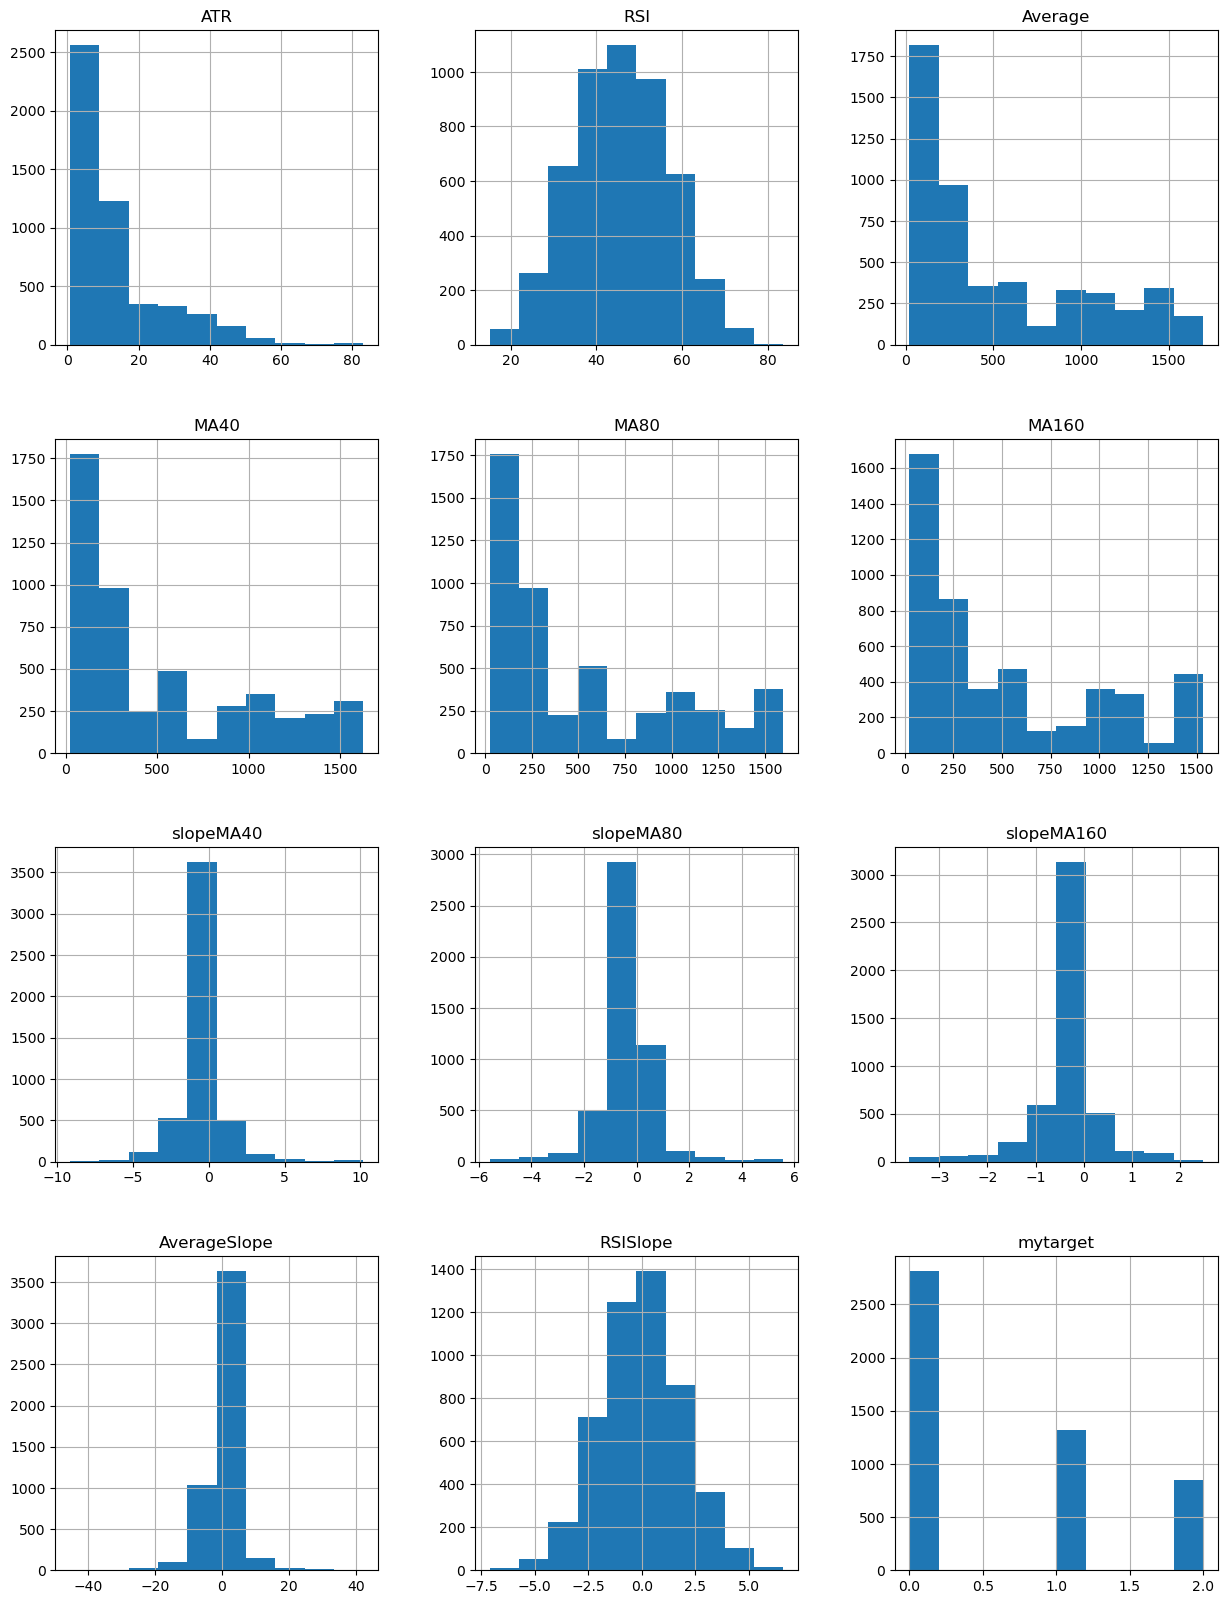

In [178]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df_model= df[['Vol.', 'ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope', 'mytarget']] 
df_model.hist(ax = ax)
plt.show()

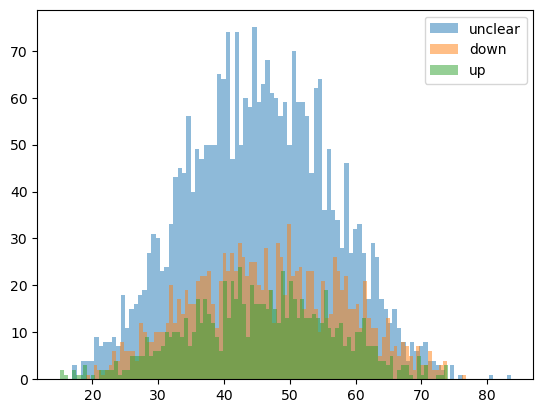

In [180]:
from matplotlib import pyplot
df_up=df.RSI[ df['mytarget'] == 2 ]
df_down=df.RSI[ df['mytarget'] == 1 ]
df_unclear=df.RSI[ df['mytarget'] == 0 ]
pyplot.hist(df_unclear, bins=100, alpha=0.5, label='unclear')
pyplot.hist(df_down, bins=100, alpha=0.5, label='down')
pyplot.hist(df_up, bins=100, alpha=0.5, label='up')

pyplot.legend(loc='upper right')
pyplot.show()

In [181]:
df_model=df_model.dropna()

attributes=['ATR', 'RSI', 'Average', 'MA40', 'MA80', 'MA160', 'slopeMA40', 'slopeMA80', 'slopeMA160', 'AverageSlope', 'RSISlope']
X = df_model[attributes]
y = df_model["mytarget"]

print(X)

            ATR        RSI   Average        MA40         MA80        MA160  \
164   28.661460  26.119233  1285.300  1384.61625  1426.277500  1506.115000   
165   29.356033  24.733612  1299.275  1379.52000  1424.671250  1503.799687   
166   29.613283  36.041511  1307.100  1375.06375  1423.506250  1501.603750   
167   29.182537  37.792753  1315.500  1371.20625  1422.218750  1499.782813   
168   28.808343  43.169908  1319.150  1367.82000  1420.916250  1497.901875   
...         ...        ...       ...         ...          ...          ...   
4977   0.782426  37.387239    23.225    24.17825    24.243500    25.537750   
4978   0.808804  26.637187    22.735    24.15925    24.218500    25.509813   
4979   0.833364  31.812277    23.295    24.14225    24.201625    25.487562   
4980   0.886196  36.805055    22.995    24.15400    24.185000    25.461750   
4981   0.879386  46.534201    23.675    24.15450    24.169875    25.437188   

      slopeMA40  slopeMA80  slopeMA160  AverageSlope  RSISlope 

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [183]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=500, weights='uniform', algorithm='kd_tree', leaf_size=30, p=1, metric='minkowski', metric_params=None, n_jobs=1)
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [184]:
from sklearn.metrics import accuracy_score

accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
print("Accuracy test: %.2f%%" % (accuracy_test * 100.0))

print(df_model['mytarget'].value_counts()*100/df_model['mytarget'].count())

# Random Model, gambler?
pred_test = np.random.choice([0, 1, 2], len(y_pred_test))
accuracy_test = accuracy_score(y_test, pred_test)
print("Accuracy Gambler: %.2f%%" % (accuracy_test * 100.0))

Accuracy train: 56.88%
Accuracy test: 56.33%
0.0    56.766293
1.0    26.691573
2.0    16.542134
Name: mytarget, dtype: float64
Accuracy Gambler: 32.26%


In [187]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 96.3415%
****Test Results****
Accuracy: 69.6058%


In [188]:
train_index = int(0.8 * len(X))
y_train, y_test = y[:train_index], y[train_index:]
X_train, X_test = X[:train_index], X[train_index:]

model = XGBClassifier()
model.fit(X_train, y_train)
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
acc_train = accuracy_score(y_train, pred_train)
acc_test = accuracy_score(y_test, pred_test)
print('****Train Results****')
print("Accuracy: {:.4%}".format(acc_train))
print('****Test Results****')
print("Accuracy: {:.4%}".format(acc_test))

****Train Results****
Accuracy: 96.3415%
****Test Results****
Accuracy: 69.6058%


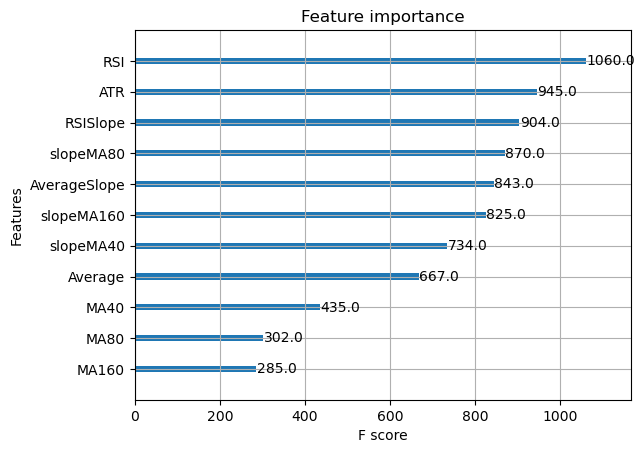

In [189]:
from matplotlib import pyplot
from xgboost import plot_importance
#plot feature importance
plot_importance(model)
pyplot.show()

In [190]:
df

,Date,close,open,high,low,Vol.,Change %,ATR,RSI,Average,MA40,MA80,MA160,slopeMA40,slopeMA80,slopeMA160,AverageSlope,RSISlope,mytarget
0,02/13/2023,1658.35,1655.00,1661.75,1644.55,2.87M,0.08%,NaN,NaN,1653.150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,02-10-2023,1657.10,1648.80,1658.50,1642.20,4.09M,0.40%,NaN,NaN,1650.350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,02-09-2023,1650.55,1660.00,1661.65,1635.55,5.89M,-0.21%,NaN,NaN,1648.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,02-08-2023,1654.00,1654.25,1668.20,1650.00,4.22M,-0.01%,NaN,NaN,1659.100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,02-07-2023,1654.20,1659.40,1664.90,1632.60,5.13M,0.15%,NaN,NaN,1648.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,01-07-2003,21.72,21.45,21.75,21.41,889.01K,1.31%,0.782503,34.534288,21.580,23.58175,23.77250,24.945563,-0.060614,-0.037032,-0.039950,-0.030714,0.576873,NaN
4996,01-06-2003,21.44,21.49,21.55,21.36,909.09K,-0.28%,0.761377,31.808225,21.455,23.51175,23.72850,24.905500,-0.062771,-0.038600,-0.040086,-0.005571,0.983508,NaN
4997,01-03-2003,21.50,21.51,21.80,21.45,342.11K,-1.33%,0.741309,33.028212,21.625,23.44350,23.68225,24.864625,-0.064164,-0.040293,-0.040393,0.060000,1.330045,NaN
4998,01-02-2003,21.79,21.65,21.85,21.44,315.39K,1.30%,0.724743,38.733501,21.645,23.36500,23.64650,24.820563,-0.067436,-0.041007,-0.041148,0.055714,1.934725,NaN


In [135]:
data = pd.DataFrame(df) 
  
# storing into the excel file
data.to_excel("output2.xlsx")